<a href="https://colab.research.google.com/github/Benqui/facial-recognition-on-keras/blob/main/camamra/opencv_mark03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keyboard  # Install the keyboard module

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [3]:
import numpy as np
from tensorflow import keras
import argparse
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [6]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [7]:
def take_photo(modelo,filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const video = document.createElement('video');
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });

            document.body.appendChild(video);
            video.srcObject = stream;
            await video.play();

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            document.body.removeChild(video);
            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)
    
    # model = Sequential()
    model = modelo
    # model.keras.models.load_model('/content/drive/MyDrive/Escuela/ia/reconocer-jetas/modelos_propios/mi_modelo_cuarentav3.h5')
    cv2.ocl.setUseOpenCL(False)

    emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}
        # start the webcam feed
    cap = cv2.VideoCapture(0)
    while True:
        # Find haar cascade to draw bounding box around face
        ret, frame = cap.read()
        if not ret:
            break
        facecasc = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=5)

        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
            roi_gray = gray[y:y + h, x:x + w]
            cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
            prediction = model.predict(cropped_img)
            maxindex = int(np.argmax(prediction))
            cv2.putText(frame, emotion_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        cv2.imshow('Video', cv2.resize(frame,(1600,960),interpolation = cv2.INTER_CUBIC))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    # Get photo data
    data = eval_js('takePhoto({})'.format(quality))
    # Get OpenCV format image
    img = js_to_image(data) 
    # Grayscale img
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    print(gray.shape)
    # Get face bounding box coordinates using Haar Cascade
    faces = face_cascade.detectMultiScale(gray)
    # Draw face bounding box on image
    for (x, y, w, h) in faces:
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    # Save image
    cv2.imwrite(filename, img)

    return filename

In [8]:
# try:
#   filename = take_photo('photo.jpg')
#   print('Saved to {}'.format(filename))
  
#   # Show the image which was just taken.
#   display(Image(filename))
# except Exception as err:
#   # Errors will be thrown if the user does not have a webcam or if they do not
#   # grant the page permission to access it.
#   print(str(err))

In [9]:
model= keras.models.load_model('/content/drive/MyDrive/Escuela/ia/reconocer-jetas/modelos_propios/mi_modelo_cuarentav3.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout_3 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 32)                262176    
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                      

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


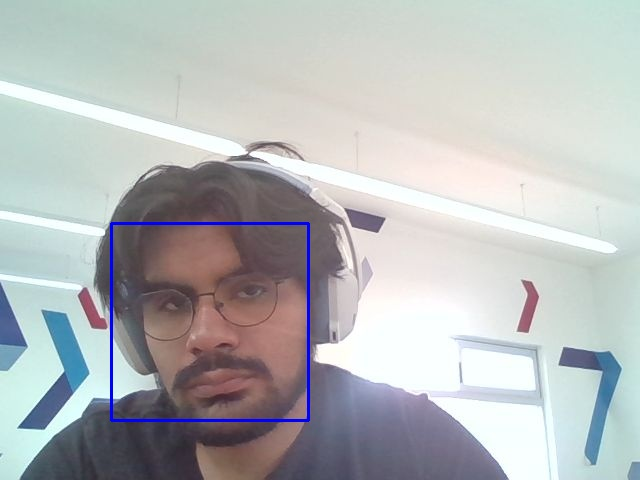

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


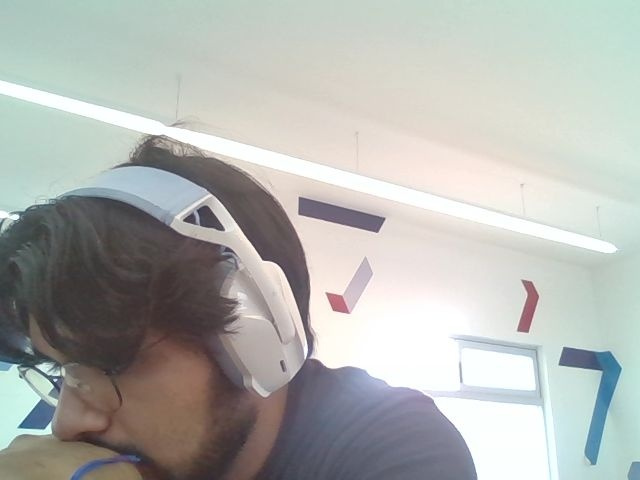

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


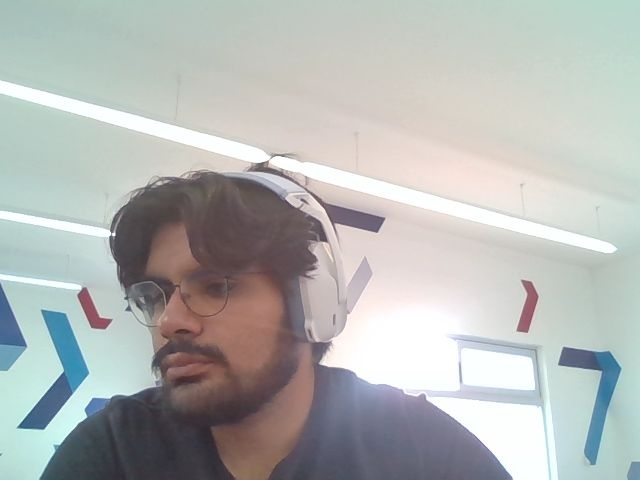

In [18]:


# import keyboard
x=0
while x<3:
  # if keyboard.is_pressed('q'):
  #   break
  #   # Continue with the rest of your loop logic here
  #   # ...

  try:
    filename = take_photo(modelo=model,filename='photo.jpg')
    print('Saved to {}'.format(filename))
    
    # Show the image which was just taken.
    display(Image(filename))
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))

  x += 1
  time.sleep(15)

In [12]:
# def video_testo(modelo):
#   cv2.ocl.setUseOpenCL(False)

#   # dictionary mapping class labels with corresponding emotions
#   emotion_dict = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3,
#            'Sad': 4, 'Surprise': 5, 'Neutral': 6}

#   # start the webcam feed
#   cap = cv2.VideoCapture(0)

#   # To find haar cascade to draw bounding box around face
#   facecasc = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
#   while True:
#       # Capture frame
#       ret, frame = cap.read()
#       if not ret:
#           break;    
      
#       gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#       faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=5)

#       for (x, y, w, h) in faces:
#           cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
#           roi_gray = gray[y:y + h, x:x + w]
#           cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
#           prediction = modelo.predict(cropped_img)
#           maxindex = int(np.argmax(prediction))
#           cv2.putText(frame, emotion_dict[maxindex], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv2.LINE_AA)
#       cv2.imshow('Video', cv2.resize(frame,(640, 480),interpolation = cv2.INTER_CUBIC))
      
#       # press 'q' to quit webcam feed
#       if cv2.waitKey(1) & 0xFF == ord('q'):
#           break
          
#   cap.release()
#   cv2.destroyAllWindows()

In [15]:
def video_testo(modelo):
    cv2.ocl.setUseOpenCL(False)

    # dictionary mapping class labels with corresponding emotions
    emotion_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
                    4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

    # start the webcam feed
    cap = cv2.VideoCapture(0)

    # To find haar cascade to draw bounding box around face
    facecasc = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    while True:
        # Capture frame
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = facecasc.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
            roi_gray = gray[y:y + h, x:x + w]
            cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
            prediction = modelo.predict(cropped_img)
            maxindex = int(np.argmax(prediction))
            cv2.putText(frame, emotion_dict[maxindex], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.imshow('Video', cv2.resize(frame, (640, 480), interpolation=cv2.INTER_CUBIC))

        # press 'q' to quit webcam feed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [16]:
video_testo(modelo=model)

In [17]:

# prevents openCL usage and unnecessary logging messages
cv2.ocl.setUseOpenCL(False)
# dictionary which assigns each label an emotion (alphabetical order)
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}
# start the webcam feed
cap = cv2.VideoCapture(0)

while True:
    # Find haar cascade to draw bounding box around face
    ret, frame = cap.read()
    if not ret:
        break
    facecasc = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=5)
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        prediction = model.predict(cropped_img)
        maxindex = int(np.argmax(prediction))
        cv2.putText(frame, emotion_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.imshow('Video', cv2.resize(frame,(1600,960),interpolation = cv2.INTER_CUBIC))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()